In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('data/case_data_calls_reservations_preprocessed.csv')

In [3]:
df.head()

,date,calls,weekday,reservations_2months_advance,total_reservations,summer_break,christmas_break,special_day
0,2014-01-01,1327,3,1494,7794,0,1,1
1,2014-01-02,3417,4,2891,20074,0,1,0
2,2014-01-03,3178,5,2790,17905,0,1,0
3,2014-01-04,1767,6,2504,10880,0,0,0
4,2014-01-05,1374,7,1522,8333,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date                          790 non-null    object
 1   calls                         790 non-null    int64 
 2   weekday                       790 non-null    int64 
 3   reservations_2months_advance  790 non-null    int64 
 4   total_reservations            790 non-null    int64 
 5   summer_break                  790 non-null    int64 
 6   christmas_break               790 non-null    int64 
 7   special_day                   790 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 49.5+ KB


In [7]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])


In [8]:
# Continue with datetime operations without setting 'date' as index
df['dayofweek'] = df['date'].dt.dayofweek
df['weekday'] = df['date'].dt.day_name()
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [9]:
df.head()

,date,calls,weekday,reservations_2months_advance,total_reservations,summer_break,christmas_break,special_day,dayofweek,quarter,month,year
0,2014-01-01,1327,Wednesday,1494,7794,0,1,1,2,1,1,2014
1,2014-01-02,3417,Thursday,2891,20074,0,1,0,3,1,1,2014
2,2014-01-03,3178,Friday,2790,17905,0,1,0,4,1,1,2014
3,2014-01-04,1767,Saturday,2504,10880,0,0,0,5,1,1,2014
4,2014-01-05,1374,Sunday,1522,8333,0,0,0,6,1,1,2014


In [12]:
df=df.sort_values('date').reset_index(drop=True)

In [13]:
#add lag features

for lag in [1, 7, 14, 30]:  # yesterday, last week, 2 weeks, 1 month ago
    df[f'calls_lag_{lag}'] = df['calls'].shift(lag)
    df[f'total_reservations_lag_{lag}'] = df['total_reservations'].shift(lag)
    df[f'reservations_2months_lag_{lag}'] = df['reservations_2months_advance'].shift(lag)


In [14]:
#rolling stats
for window in [7, 14, 30]:
    df[f'calls_roll_mean_{window}'] = df['calls'].shift(1).rolling(window).mean()
    df[f'calls_roll_std_{window}']  = df['calls'].shift(1).rolling(window).std()
    df[f'calls_roll_min_{window}']  = df['calls'].shift(1).rolling(window).min()
    df[f'calls_roll_max_{window}']  = df['calls'].shift(1).rolling(window).max()
    
    df[f'reservations_roll_mean_{window}'] = df['total_reservations'].shift(1).rolling(window).mean()
    df[f'reservations_roll_std_{window}']  = df['total_reservations'].shift(1).rolling(window).std()


In [15]:
#cumulative features

# Capture long-term growth or averages
df['calls_cum_mean'] = df['calls'].expanding().mean()
df['calls_cum_sum']  = df['calls'].expanding().sum()

df['reservations_cum_mean'] = df['total_reservations'].expanding().mean()
df['reservations_cum_sum']  = df['total_reservations'].expanding().sum()


In [16]:
# Additional Date Features
#periodic patterns
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)   # Saturday=5, Sunday=6
df['dayofyear'] = df['date'].dt.dayofyear
df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)

In [17]:
#interaction features
# Capture ratios and per-unit measures
df['reservations_ratio'] = df['reservations_2months_advance'] / (df['total_reservations'] + 1)
df['calls_per_reservation'] = df['calls'] / (df['total_reservations'] + 1)


In [18]:
#seasonal(fouruer) features
# Great for capturing yearly cycles
df['sin_dayofyear'] = np.sin(2 * np.pi * df['dayofyear'] / 365.25)
df['cos_dayofyear'] = np.cos(2 * np.pi * df['dayofyear'] / 365.25)



In [19]:
#event proximity features
# Days before / after important events (holidays, breaks)
df['days_until_christmas'] = (pd.to_datetime(df['year'].astype(str) + '-12-25') - df['date']).dt.days
df['days_since_christmas'] = (df['date'] - pd.to_datetime(df['year'].astype(str) + '-12-25')).dt.days


In [20]:
def add_event_proximity(df, event_col, event_name):
    """
    Add 'days_since_event' and 'days_until_event' features 
    for a given binary event column.
    """
    df = df.copy()
    event_idx = df.index[df[event_col] == 1].tolist()
    
    # Days since last event
    last_event = -1e9
    days_since = []
    for i in range(len(df)):
        if i in event_idx:
            last_event = i
        days_since.append(i - last_event)
    df[f'days_since_{event_name}'] = days_since

    # Days until next event
    next_event = 1e9
    days_until = []
    for i in range(len(df)-1, -1, -1):
        if i in event_idx:
            next_event = i
        days_until.append(next_event - i)
    df[f'days_until_{event_name}'] = days_until[::-1]

    return df

# =======================
# Apply for your dataset
# =======================
df = add_event_proximity(df, 'summer_break', 'summer')
df = add_event_proximity(df, 'christmas_break', 'christmas')
df = add_event_proximity(df, 'special_day', 'special')


In [22]:
print(df.head())

        date  calls    weekday  reservations_2months_advance  \
0 2014-01-01   1327  Wednesday                          1494   
1 2014-01-02   3417   Thursday                          2891   
2 2014-01-03   3178     Friday                          2790   
3 2014-01-04   1767   Saturday                          2504   
4 2014-01-05   1374     Sunday                          1522   

   total_reservations  summer_break  christmas_break  special_day  dayofweek  \
0                7794             0                1            1          2   
1               20074             0                1            0          3   
2               17905             0                1            0          4   
3               10880             0                0            0          5   
4                8333             0                0            0          6   

   quarter  ...  reservations_ratio  calls_per_reservation  sin_dayofyear  \
0        1  ...            0.191661               0.17023

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use("seaborn-v0_8")
sns.set(rc={"figure.figsize":(12,6)})

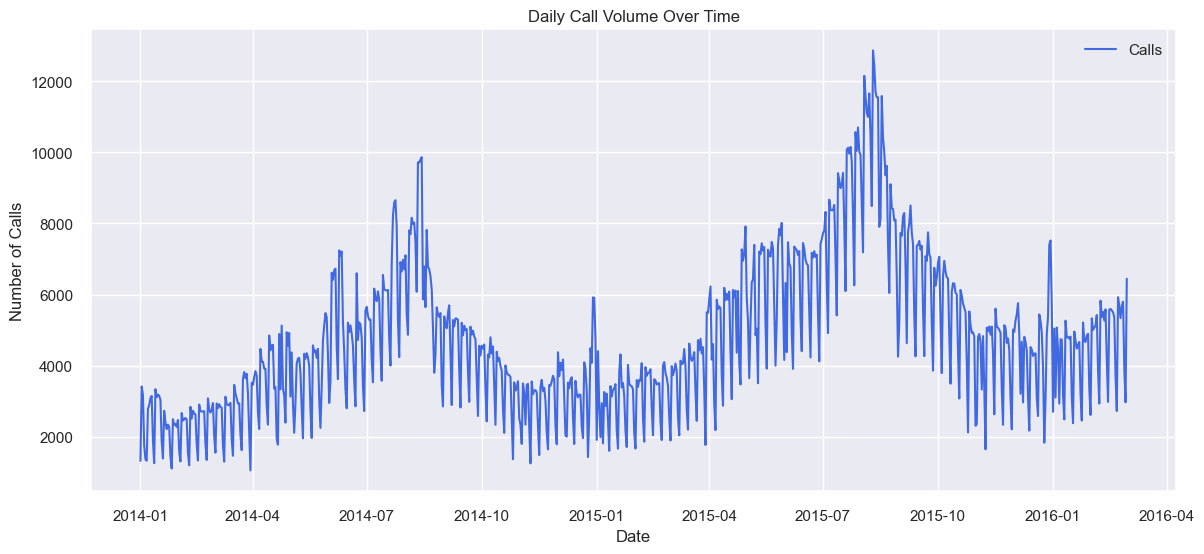

C:\Users\Kawishka\AppData\Local\Temp\ipykernel_14892\3040721102.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dayofweek', y='calls', data=df, palette="coolwarm")


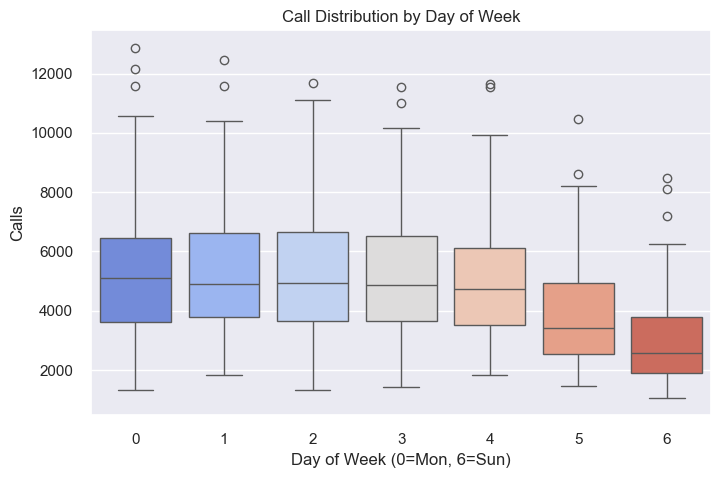

C:\Users\Kawishka\AppData\Local\Temp\ipykernel_14892\3040721102.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_calls.index, y=monthly_calls.values, palette="mako")


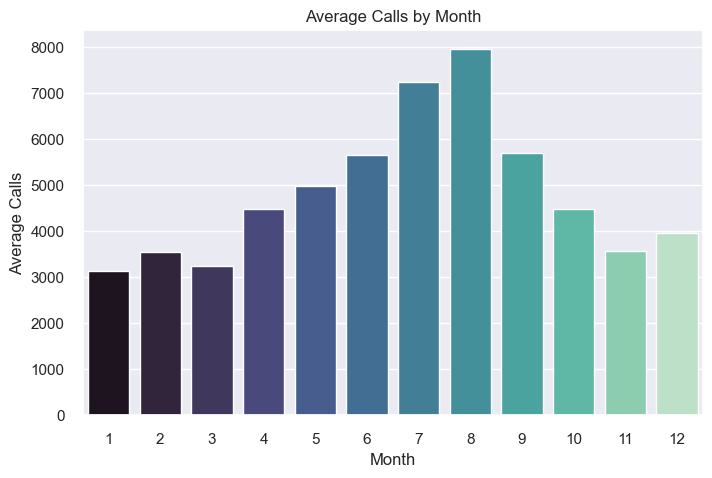

C:\Users\Kawishka\AppData\Local\Temp\ipykernel_14892\3040721102.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='summer_break', y='calls', data=df, palette="Set2")


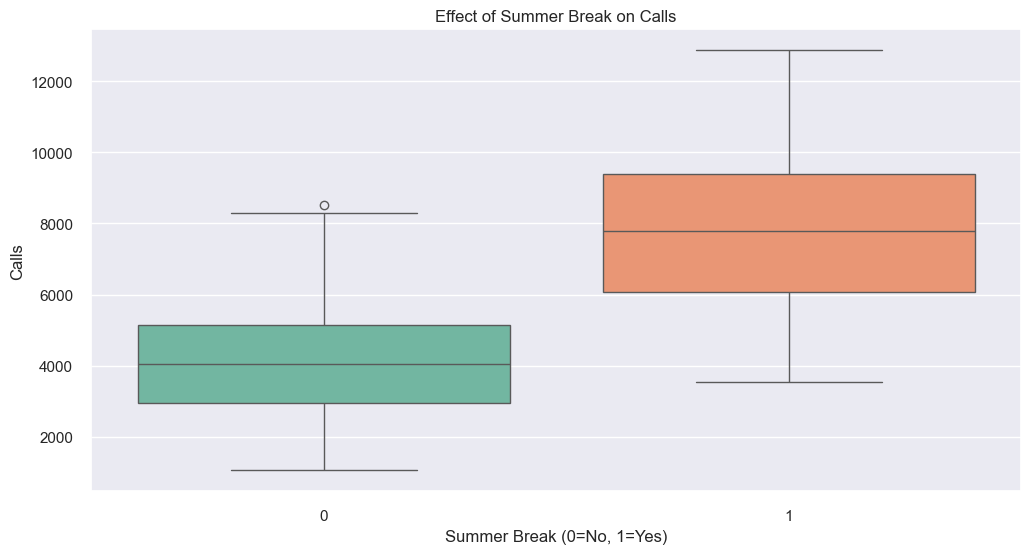

C:\Users\Kawishka\AppData\Local\Temp\ipykernel_14892\3040721102.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='christmas_break', y='calls', data=df, palette="Set3")


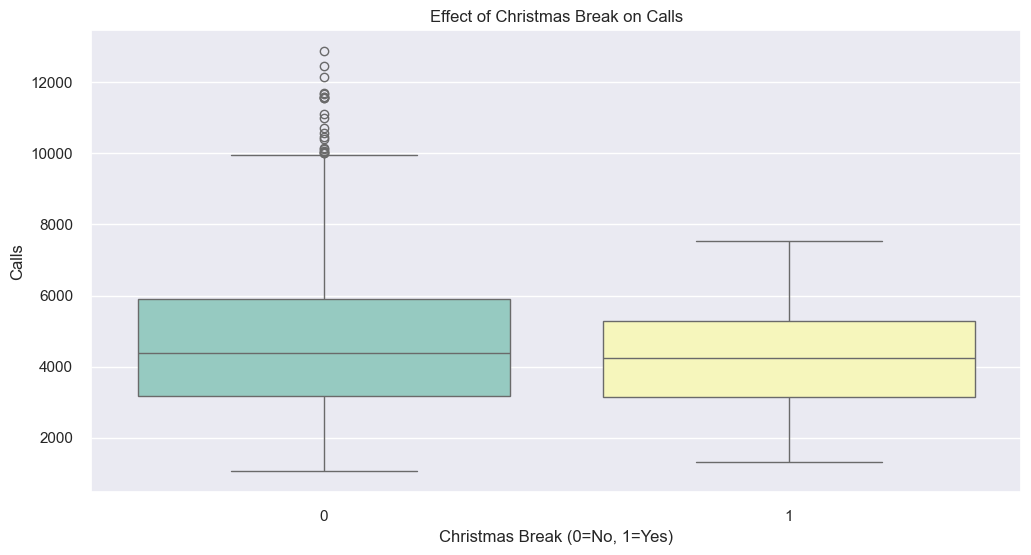

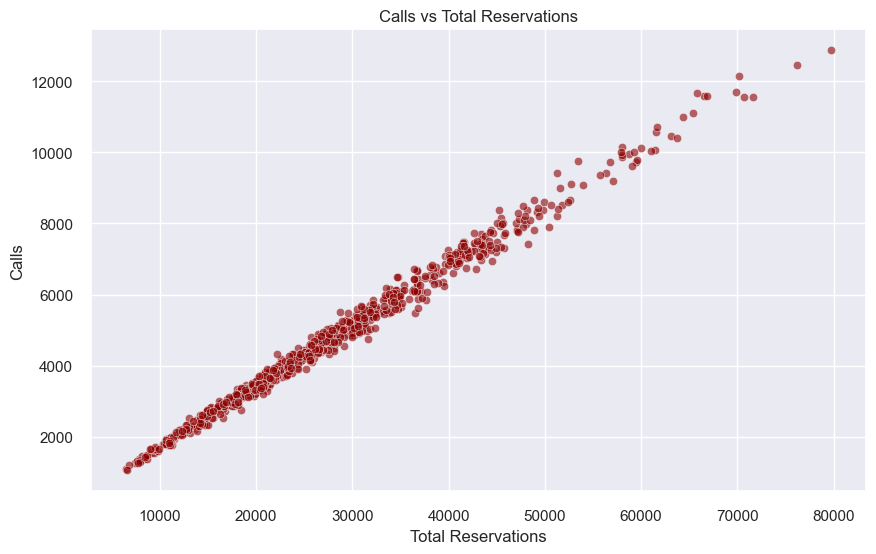

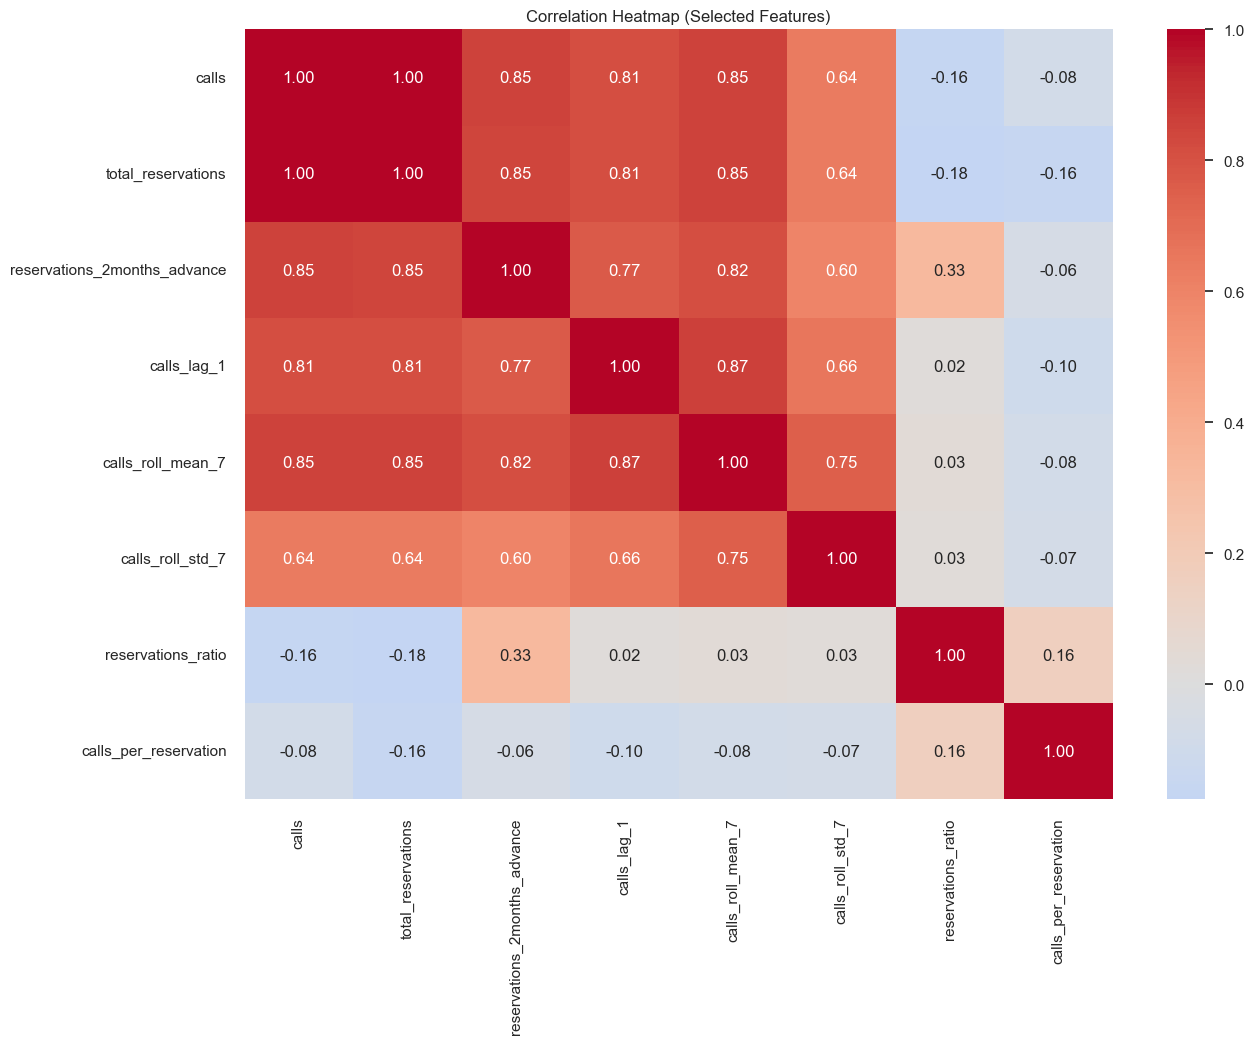

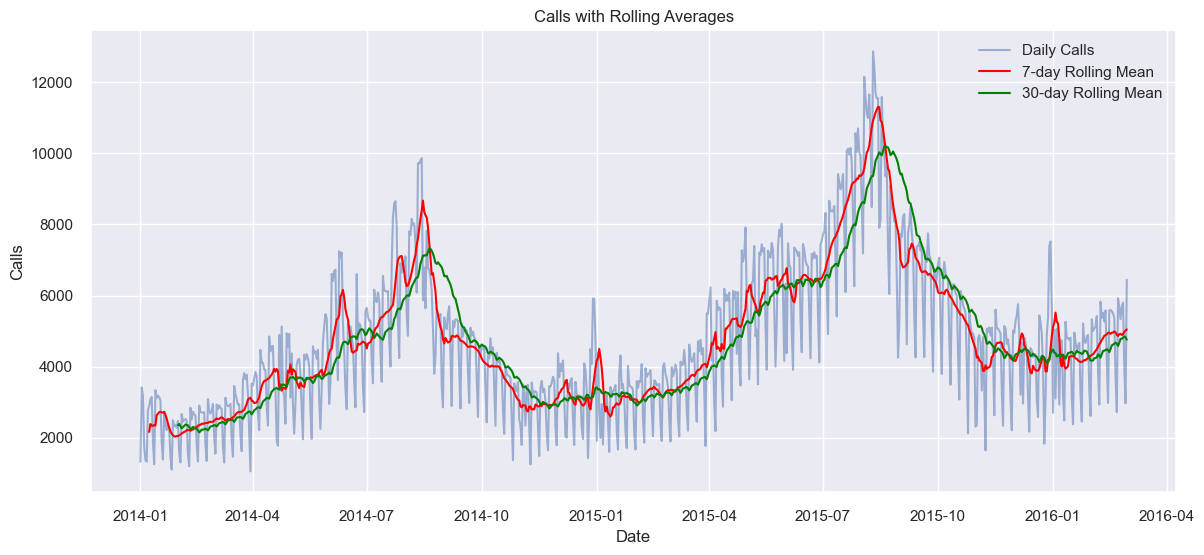

In [24]:
# 1. Line plot of calls over time
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['calls'], label="Calls", color="royalblue")
plt.title("Daily Call Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Calls")
plt.legend()
plt.show()


# 2. Calls grouped by day of week

plt.figure(figsize=(8,5))
sns.boxplot(x='dayofweek', y='calls', data=df, palette="coolwarm")
plt.title("Call Distribution by Day of Week")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Calls")
plt.show()


# 3. Seasonality: Calls by Month

monthly_calls = df.groupby('month')['calls'].mean()
plt.figure(figsize=(8,5))
sns.barplot(x=monthly_calls.index, y=monthly_calls.values, palette="mako")
plt.title("Average Calls by Month")
plt.xlabel("Month")
plt.ylabel("Average Calls")
plt.show()


# 4. Effect of Breaks on Calls

plt.figure(figsize=(12,6))
sns.boxplot(x='summer_break', y='calls', data=df, palette="Set2")
plt.title("Effect of Summer Break on Calls")
plt.xlabel("Summer Break (0=No, 1=Yes)")
plt.ylabel("Calls")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x='christmas_break', y='calls', data=df, palette="Set3")
plt.title("Effect of Christmas Break on Calls")
plt.xlabel("Christmas Break (0=No, 1=Yes)")
plt.ylabel("Calls")
plt.show()

# 5. Calls vs Reservations

plt.figure(figsize=(10,6))
sns.scatterplot(x='total_reservations', y='calls', data=df, alpha=0.6, color="darkred")
plt.title("Calls vs Total Reservations")
plt.xlabel("Total Reservations")
plt.ylabel("Calls")
plt.show()


# 6. Correlation Heatmap (Top Features)

plt.figure(figsize=(14,10))
corr = df[['calls','total_reservations','reservations_2months_advance',
           'calls_lag_1','calls_roll_mean_7','calls_roll_std_7',
           'reservations_ratio','calls_per_reservation']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Selected Features)")
plt.show()


# 7. Rolling Average Visualization

plt.figure(figsize=(14,6))
plt.plot(df['date'], df['calls'], label="Daily Calls", alpha=0.5)
plt.plot(df['date'], df['calls_roll_mean_7'], label="7-day Rolling Mean", color="red")
plt.plot(df['date'], df['calls_roll_mean_30'], label="30-day Rolling Mean", color="green")
plt.title("Calls with Rolling Averages")
plt.xlabel("Date")
plt.ylabel("Calls")
plt.legend()
plt.show()

In [25]:
# Final Step: Drop NaNs caused by shifting/rolling
df = df.dropna().reset_index(drop=True)

In [32]:
print("📅 Start date:", df['date'].min())
print("📅 End date:", df['date'].max())


📅 Start date: 2014-01-31 00:00:00
📅 End date: 2016-02-29 00:00:00


In [26]:
#create train text data files
from sklearn.model_selection import train_test_split

In [27]:
#Export full feature engineered dataset

df.to_csv("data/df_full_feature_engineered.csv", index=False)

In [28]:
# 2Train-Test Split (80:20)
# Use time-based split since this is time series
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [29]:
# Export train set (all features)
train_df.to_csv("data/train.csv", index=False)

In [31]:
# Export Test Set (only date & target)
test_df_minimal = test_df[['date', 'calls']]
test_df_minimal.to_csv("data/test.csv", index=False)